In [1]:
# test for cuda and cudnn
import torch
print("version", torch.__version__)
print("cuda available", torch.cuda.is_available())
print("cudnn", torch.backends.cudnn.enabled)
print("device_name", torch.cuda.get_device_name(0))
print("device count", torch.cuda.device_count())
print("current dev", torch.cuda.current_device())
print("device zero", torch.cuda.device(0))


version 2.1.2
cuda available True
cudnn True
device_name NVIDIA GeForce GTX TITAN X
device count 4
current dev 0
device zero <torch.cuda.device object at 0x7fbcc8634be0>


## RETRIEVE LOGS

In [2]:
import os
import shutil
import glob

#### CLEAN UP MEMMAP BUFFER FOLDERS ####

# Iterate through each EXP_NAME folder
count = 0
for game_dir in glob.glob(os.path.join('logs/runs/dreamer_v3', '*')):
    for exp_dir in glob.glob(os.path.join(game_dir, '*')):
        version_dir = os.path.join(exp_dir, 'version_0')
        test_videos_path = os.path.join(version_dir, 'test_videos')
        memmap_buffer_path = os.path.join(version_dir, 'memmap_buffer')

        # Check if test_videos exists
        if os.path.exists(test_videos_path) and os.path.isdir(memmap_buffer_path):
            count += 1
            # Delete the contents of memmap_buffer
            for file in os.listdir(memmap_buffer_path):
                file_path = os.path.join(memmap_buffer_path, file)
                try:
                    if os.path.isfile(file_path) or os.path.islink(file_path):
                        os.unlink(file_path)
                    elif os.path.isdir(file_path):
                        shutil.rmtree(file_path)
                except Exception as e:
                    print(f"Failed to delete {file_path}. Reason: {e}")
            # delete folder
            os.rmdir(memmap_buffer_path)

print(f"Total number of experiments processed/memmap deleted: {count}")

Total number of experiments processed/memmap deleted: 0


In [3]:
import os
import pandas as pd
from cv2 import exp
import pandas as pd
from requests import get
import yaml
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import seaborn as sns

from sheeprl.algos.a2c.a2c import train

def create_experiment_df(tensorboard_path, config_path):
    # Load TensorBoard data
    ea = event_accumulator.EventAccumulator(tensorboard_path)
    ea.Reload()

    # Load config data
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)

    # Extract parameters from config
    def get_model_size(model_size):
        if model_size == 256:
            return 'XS'
        elif model_size == 512:
            return 'S'
        else:
            return 'Not found'
        
    def get_ae_keys(mlp_keys: dict, cnn_keys: dict):
        if mlp_keys['encoder'] == []:
            return 'None'
        elif cnn_keys['encoder'] == []:
            return 'obj_only'
        elif mlp_keys['decoder'] == ["objects_position"]:
            return 'obj_autoencoding'
        elif mlp_keys['encoder'] == ["objects_position"]:
            return 'obj_enconding_only'
        else:
            return 'Not found'
        
    def get_env_target(env_target):
        if env_target == "gymnasium.make":
            return 'gym'
        elif env_target == "sheeprl.envs.ocatari.OCAtariWrapper":
            return 'ocatari'
        else:
            return 'Not found'

    params = {
        'seed': config.get('seed', 'Not found'),
        'ae_keys': get_ae_keys(config.get('algo', {}).get('mlp_keys', 'Not found'), config.get('algo', {}).get('cnn_keys', 'Not found')),
        'train_every': config.get('algo', {}).get('train_every', 'Not found'),
        'model_size': get_model_size(config.get('algo', {}).get('dense_units', 'Not found')),
        'env_target': get_env_target(config.get('env', {}).get('wrapper', {}).get('env', {}).get('_target_', 'Not found')),
        'run_name': config.get('run_name', 'Not found'),
    }
    # Extract metrics and populate DataFrame
    list_of_entries = []
    for key in ea.scalars.Keys():
        # skip hp_metric
        if key == 'hp_metric':
            continue
        for event in ea.Scalars(key):
            list_of_entries.append({
                'Metric': key,
                'Step': event.step,
                'Value': event.value,
                'Seed': params['seed'],
                'AE_Keys': params['ae_keys'],
                'Train_Every': params['train_every'],
                'Model_Size': params['model_size'],
                'Env_Target': params['env_target'],
                'Run_ID': params['run_name'],
            })
    df = pd.DataFrame.from_records(list_of_entries, columns=['Metric', 'Step', 'Value', 'Seed', 'AE_Keys', 'Train_Every', 'Model_Size', 'Env_Target', 'Run_ID'])
    return df

def process_all_experiments(logs_base_dir):
    # Pattern for TensorFlow event files and config files
    tf_event_pattern = 'events.out.tfevents.*'
    config_filename = 'config.yaml'

    # List to hold DataFrames from each experiment
    experiments_dfs = []

    # Iterate over each subdirectory in the logs directory
    for root, dirs, files in os.walk(logs_base_dir):
        for file in files:
            if file.startswith('events.out.tfevents'):
                # TensorFlow event file path
                tf_event_path = os.path.join(root, file)

                # Corresponding config file path
                config_path = os.path.join(root, config_filename)

                # Check if config file exists
                if os.path.exists(config_path):
                    experiment_df = create_experiment_df(tf_event_path, config_path)
                    experiments_dfs.append(experiment_df)

    # Concatenate all DataFrames into a single one
    all_experiments_df = pd.concat(experiments_dfs, ignore_index=True)
    print(f"Total number of experiments processed: {len(experiments_dfs)}")
    return all_experiments_df

def rew_barplot(df: pd.DataFrame, env_id: str, train_every: int = 2):
    sns.set_theme(style="whitegrid")
    # Plot bar plot of Test/cumulative_reward grouped by MLP_Keys, show mean and confidence interval
    plt.figure(figsize=(10, 6))
    filtered_df = df[(df['Metric']=='Test/cumulative_reward') & (df['Train_Every'] == train_every) & (df['Model_Size'] == 'S') & (df['Env_Target'] == 'ocatari')]
    filtered_df = filtered_df.drop(columns=['Env_Target', 'Run_ID', 'Metric', 'Model_Size', 'Train_Every', 'Seed', 'Step'])
    sns.set_style("whitegrid")

    # Create a bar plot showing the mean score grouped by MLP_Keys
    # Seaborn automatically calculates the confidence interval (95% by default)
    # and adds it as error bars
    plt.figure(figsize=(10, 6))
    sns.barplot(x="AE_Keys", y="Value", data=filtered_df, errorbar="sd", palette="muted", hue="AE_Keys")

    plt.title(f'Test Cumulative Reward on {env_id.replace("NoFrameskip-v4", "")} trained every {train_every}, grouped by AE_Keys (95% CI)')
    plt.xlabel('AE_Keys')
    plt.ylabel('Mean Test Reward')
    # position y-label on the top left of the plot
    plt.gca().yaxis.set_label_coords(-0.1, 0.5)

    plt.tight_layout()  # Adjust layout to make room for the rotated x-labels
    plt.savefig(f'viz/{env_id}/{train_every}_Test_cumulative_reward.png')
    plt.show()
    

def create_viz(df, env_id):

    metrics = df['Metric'].unique()
    train_every_list = df['Train_Every'].unique()
    print(f"Unique train_every: {train_every_list}")
    for train_every in train_every_list:
        if train_every not in [2, 8]:
            continue
        print(f"Plotting for train_every: {train_every}")
        for metric in metrics:
            if metric == 'hp_metric' or metric == 'Params/exploration_amount':
                continue
            print(f"Plotting for metric: {metric}")
            if metric == 'Test/cumulative_reward':
                rew_barplot(df, env_id, train_every)
                continue
            # Group by Step and Metric, then calculate mean and std
            filtered_df = df[(df['Metric']==metric) & (df['Train_Every'] == train_every) & (df['Model_Size'] == 'S') & (df['Env_Target'] == 'ocatari')]
            # get number of unique run ids by group of AE_Keys
            print(filtered_df.groupby('AE_Keys')['Run_ID'].nunique())
            grouped = filtered_df.drop(columns=['Env_Target', 'Run_ID', 'Metric', 'Model_Size', 'Train_Every', 'Seed']).groupby(['Step', 'AE_Keys'])
            mean_std_df = grouped['Value'].agg(['mean', 'std']).reset_index()
            # smoothing the plot
            mean_std_df['mean'] = mean_std_df['mean'].rolling(window=5).mean()
            #mean_std_df['std'] = mean_std_df['std'].rolling(window=3).mean()


            # Plotting
            plt.figure(figsize=(10, 6))

            # Unique AE_Keys
            ae_keys_unique = filtered_df['AE_Keys'].unique()

            for ae_key in ae_keys_unique:
                subset = mean_std_df[mean_std_df['AE_Keys'] == ae_key]
                
                # Plot mean
                plt.plot(subset['Step'], subset['mean'], label=f'AE Keys: {ae_key}')
                
                # Fill between mean ± std
                plt.fill_between(subset['Step'], subset['mean'] - subset['std'], subset['mean'] + subset['std'], alpha=0.3)

            plt.title(f'{metric} on {env_id.replace("NoFrameskip-v4", "")}, trained every {train_every}, grouped by AE_Keys')
            plt.xlabel('Step')
            plt.ylabel(f'Average {metric}')
            # log scale for y-axis if metric contains "loss" or "grad"    
            if "Loss" in metric or "Grads" in metric:
                plt.yscale('log')
            plt.legend()
            plt.savefig(f'viz/{env_id}/{train_every}_{metric.replace("/", "_")}.png')
            if metric == "Rewards/rew_avg":
                plt.show()
            else:
                plt.close()

def update_viz(path):
    all_experiments_df = process_all_experiments(path)
    env_id = path.split('/')[3]
    # make sure viz/ENV_ID directory exists before saving 
    if not os.path.exists(f'viz/{env_id}'):
        os.makedirs(f'viz/{env_id}')
    create_viz(all_experiments_df, env_id)

In [ ]:
# retrive model checkpoints and rerun test runs 5 times to get average test reward

def get_model_checkpoints(logs_base_dir):
    # iterete through each subdirectory in the logs directory
    model_checkpoints = []
    # only consider model checkpoints that start with ckpt_100000
    for root, dirs, files in os.walk(logs_base_dir):
        for file in files:
            if file.startswith('ckpt_100000'):
                model_checkpoints.append(os.path.join(root, file))
    

Processing MsPacman...


Total number of experiments processed: 17
Unique train_every: [8 1 2]
Plotting for train_every: 8
Plotting for metric: Rewards/rew_avg
AE_Keys
obj_autoencoding    5
obj_only            3
Name: Run_ID, dtype: int64


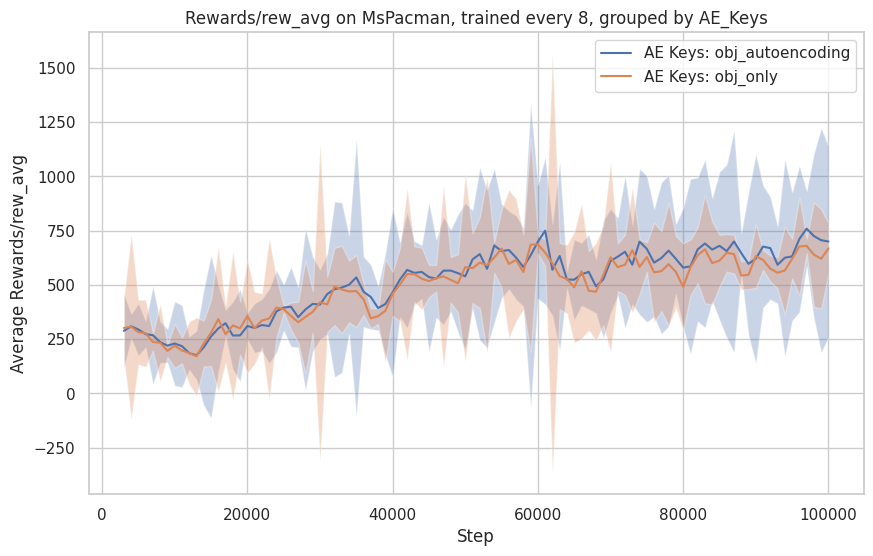

Plotting for metric: Game/ep_len_avg
AE_Keys
obj_autoencoding    5
obj_only            3
Name: Run_ID, dtype: int64
Plotting for metric: Time/sps_env_interaction
AE_Keys
obj_autoencoding    5
obj_only            3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/world_model_loss
AE_Keys
obj_autoencoding    5
obj_only            3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/value_loss
AE_Keys
obj_autoencoding    5
obj_only            3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/policy_loss
AE_Keys
obj_autoencoding    5
obj_only            3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/observation_loss
AE_Keys
obj_autoencoding    5
obj_only            3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/reward_loss
AE_Keys
obj_autoencoding    5
obj_only            3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/state_loss
AE_Keys
obj_autoencoding    5
obj_only            3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/continue_loss
AE_Keys
o

/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Figure size 1000x600 with 0 Axes>

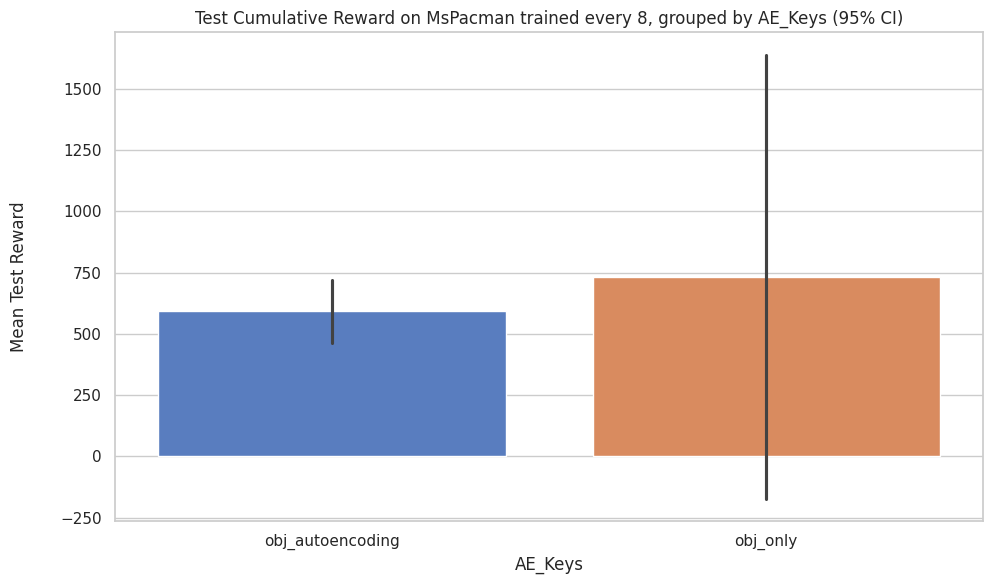

Plotting for train_every: 2
Plotting for metric: Rewards/rew_avg
AE_Keys
None                  3
obj_autoencoding      3
obj_enconding_only    1
obj_only              1
Name: Run_ID, dtype: int64


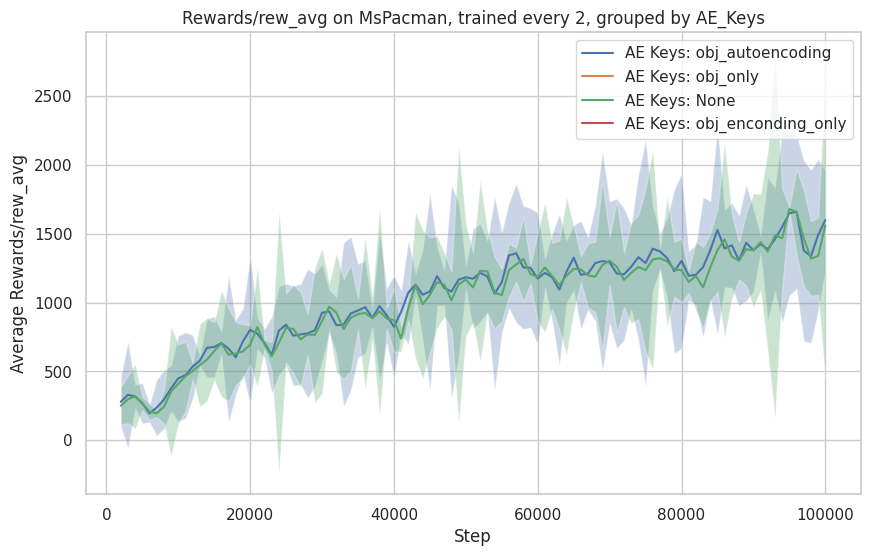

Plotting for metric: Game/ep_len_avg
AE_Keys
None                  3
obj_autoencoding      3
obj_enconding_only    1
obj_only              1
Name: Run_ID, dtype: int64
Plotting for metric: Time/sps_env_interaction
AE_Keys
None                  3
obj_autoencoding      3
obj_enconding_only    1
obj_only              1
Name: Run_ID, dtype: int64
Plotting for metric: Loss/world_model_loss
AE_Keys
None                  3
obj_autoencoding      3
obj_enconding_only    1
obj_only              1
Name: Run_ID, dtype: int64
Plotting for metric: Loss/value_loss
AE_Keys
None                  3
obj_autoencoding      3
obj_enconding_only    1
obj_only              1
Name: Run_ID, dtype: int64
Plotting for metric: Loss/policy_loss
AE_Keys
None                  3
obj_autoencoding      3
obj_enconding_only    1
obj_only              1
Name: Run_ID, dtype: int64
Plotting for metric: Loss/observation_loss
AE_Keys
None                  3
obj_autoencoding      3
obj_enconding_only    1
obj_only             

/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Figure size 1000x600 with 0 Axes>

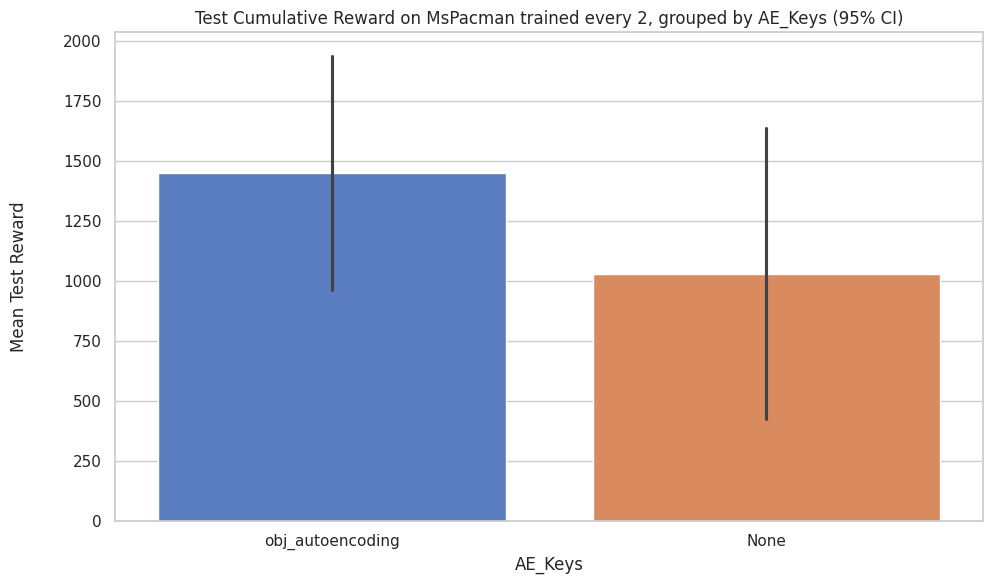

Processing Breakout...
Total number of experiments processed: 28
Unique train_every: [8]
Plotting for train_every: 8
Plotting for metric: Rewards/rew_avg
AE_Keys
None                   6
obj_autoencoding      10
obj_enconding_only     6
obj_only               6
Name: Run_ID, dtype: int64


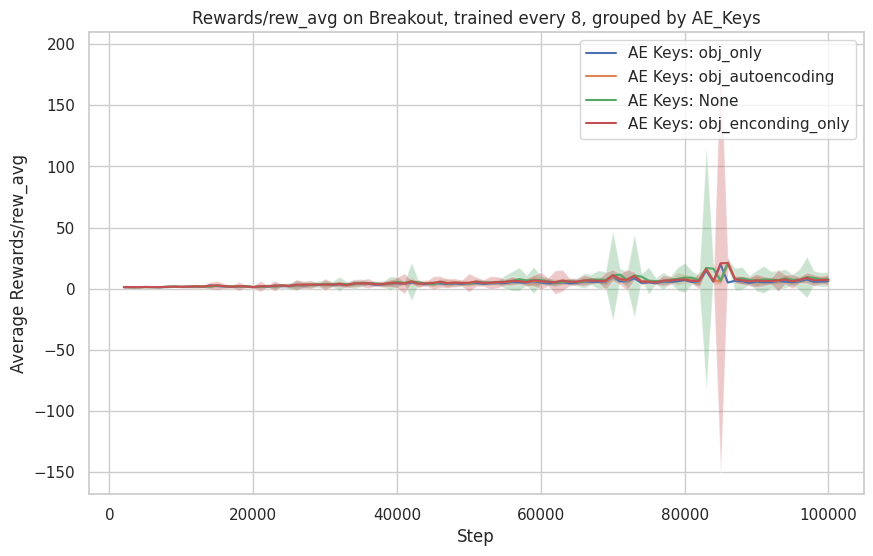

Plotting for metric: Game/ep_len_avg
AE_Keys
None                   6
obj_autoencoding      10
obj_enconding_only     6
obj_only               6
Name: Run_ID, dtype: int64
Plotting for metric: Time/sps_env_interaction
AE_Keys
None                   6
obj_autoencoding      10
obj_enconding_only     6
obj_only               6
Name: Run_ID, dtype: int64
Plotting for metric: Loss/world_model_loss
AE_Keys
None                   5
obj_autoencoding      10
obj_enconding_only     5
obj_only               6
Name: Run_ID, dtype: int64
Plotting for metric: Loss/value_loss
AE_Keys
None                   5
obj_autoencoding      10
obj_enconding_only     5
obj_only               6
Name: Run_ID, dtype: int64
Plotting for metric: Loss/policy_loss
AE_Keys
None                   5
obj_autoencoding      10
obj_enconding_only     5
obj_only               6
Name: Run_ID, dtype: int64
Plotting for metric: Loss/observation_loss
AE_Keys
None                   5
obj_autoencoding      10
obj_enconding_only     

/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

<Figure size 1000x600 with 0 Axes>

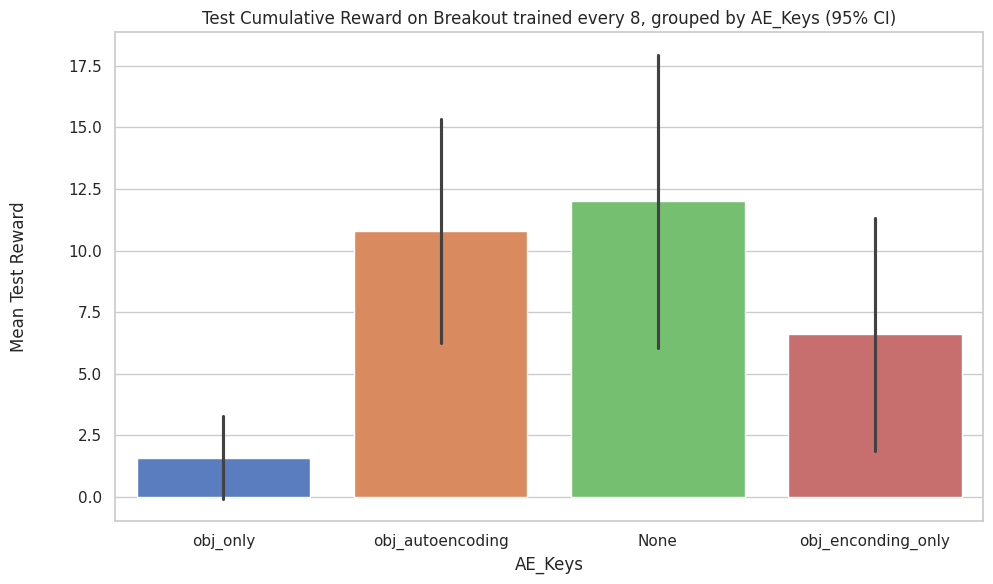

Plotting for metric: Loss/observation_loss_rgb
AE_Keys
obj_autoencoding    5
Name: Run_ID, dtype: int64
Processing Assault...
Total number of experiments processed: 22
Unique train_every: [8 2]
Plotting for train_every: 8
Plotting for metric: Rewards/rew_avg
AE_Keys
None                  3
obj_autoencoding      3
obj_enconding_only    3
obj_only              3
Name: Run_ID, dtype: int64


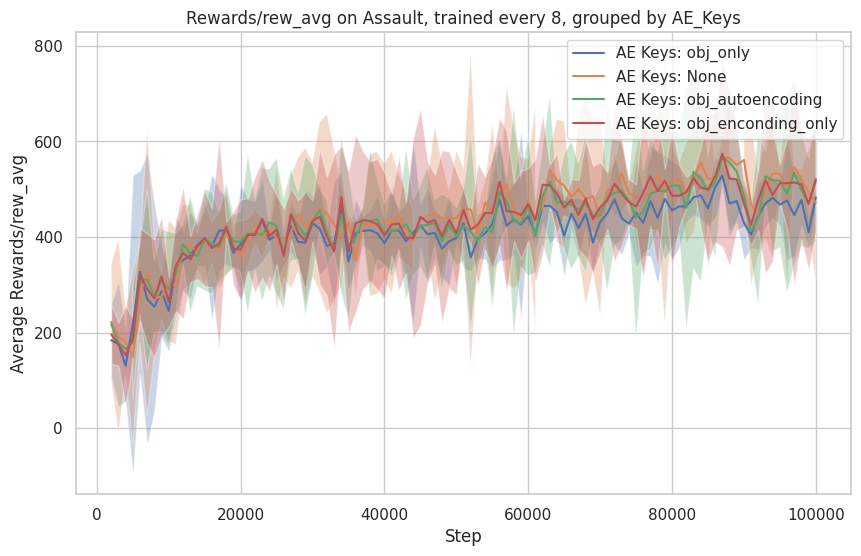

Plotting for metric: Game/ep_len_avg
AE_Keys
None                  3
obj_autoencoding      3
obj_enconding_only    3
obj_only              3
Name: Run_ID, dtype: int64
Plotting for metric: Time/sps_env_interaction
AE_Keys
None                  3
obj_autoencoding      3
obj_enconding_only    3
obj_only              3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/world_model_loss
AE_Keys
None                  3
obj_autoencoding      3
obj_enconding_only    3
obj_only              3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/value_loss
AE_Keys
None                  3
obj_autoencoding      3
obj_enconding_only    3
obj_only              3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/policy_loss
AE_Keys
None                  3
obj_autoencoding      3
obj_enconding_only    3
obj_only              3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/observation_loss
AE_Keys
None                  3
obj_autoencoding      3
obj_enconding_only    3
obj_only             

/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

<Figure size 1000x600 with 0 Axes>

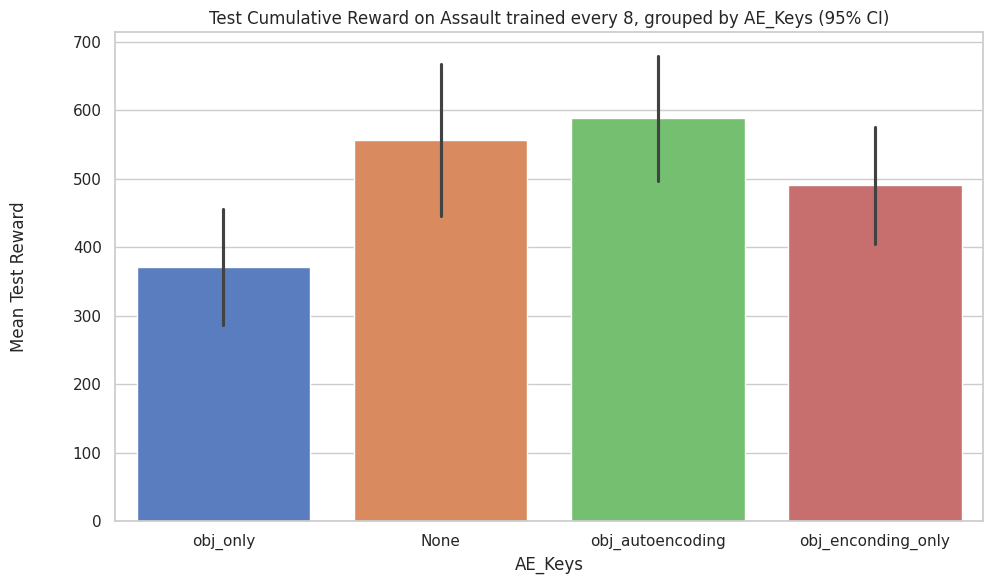

Plotting for metric: Loss/observation_loss_rgb
AE_Keys
None                  3
obj_autoencoding      3
obj_enconding_only    3
Name: Run_ID, dtype: int64
Plotting for train_every: 2
Plotting for metric: Rewards/rew_avg
AE_Keys
None                  4
obj_autoencoding      3
obj_enconding_only    1
obj_only              2
Name: Run_ID, dtype: int64


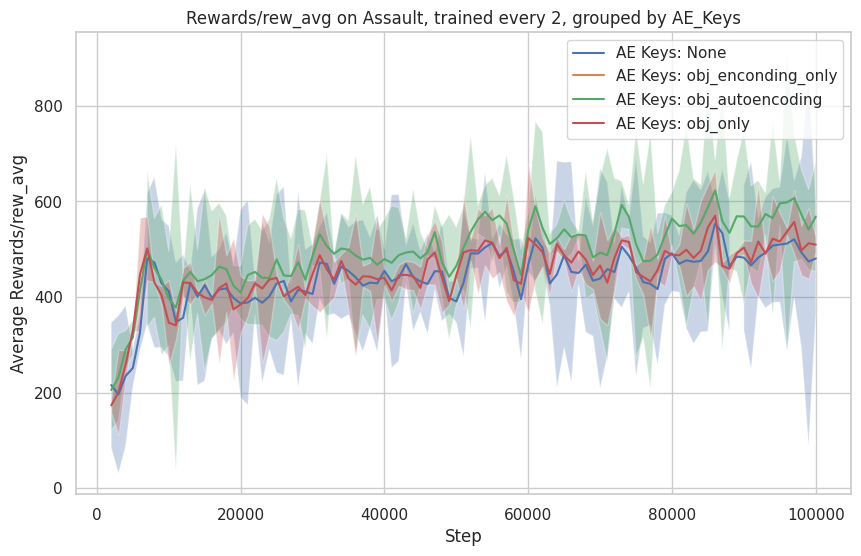

Plotting for metric: Game/ep_len_avg
AE_Keys
None                  4
obj_autoencoding      3
obj_enconding_only    1
obj_only              2
Name: Run_ID, dtype: int64
Plotting for metric: Time/sps_env_interaction
AE_Keys
None                  4
obj_autoencoding      3
obj_enconding_only    1
obj_only              2
Name: Run_ID, dtype: int64
Plotting for metric: Loss/world_model_loss
AE_Keys
None                  4
obj_autoencoding      3
obj_enconding_only    1
obj_only              2
Name: Run_ID, dtype: int64
Plotting for metric: Loss/value_loss
AE_Keys
None                  4
obj_autoencoding      3
obj_enconding_only    1
obj_only              2
Name: Run_ID, dtype: int64
Plotting for metric: Loss/policy_loss
AE_Keys
None                  4
obj_autoencoding      3
obj_enconding_only    1
obj_only              2
Name: Run_ID, dtype: int64
Plotting for metric: Loss/observation_loss
AE_Keys
None                  4
obj_autoencoding      3
obj_enconding_only    1
obj_only             

/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

<Figure size 1000x600 with 0 Axes>

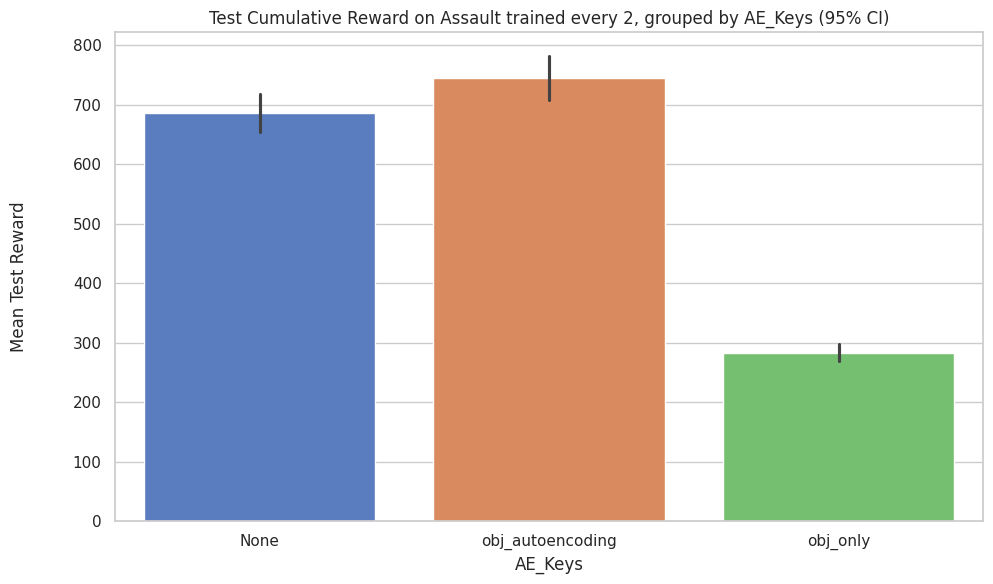

Plotting for metric: Loss/observation_loss_rgb
AE_Keys
None                  4
obj_autoencoding      3
obj_enconding_only    1
Name: Run_ID, dtype: int64
Processing Carnival...
Total number of experiments processed: 12
Unique train_every: [8]
Plotting for train_every: 8
Plotting for metric: Rewards/rew_avg
AE_Keys
None                  3
obj_autoencoding      3
obj_enconding_only    3
obj_only              3
Name: Run_ID, dtype: int64


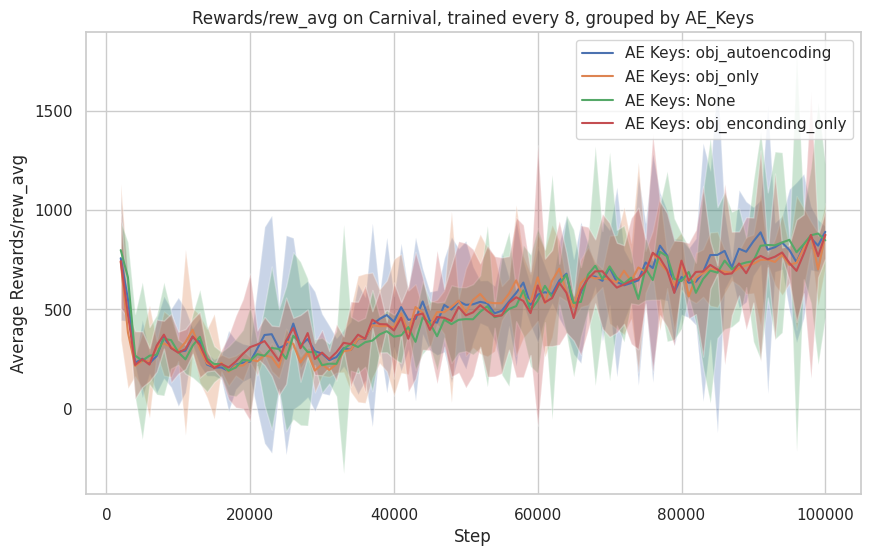

Plotting for metric: Game/ep_len_avg
AE_Keys
None                  3
obj_autoencoding      3
obj_enconding_only    3
obj_only              3
Name: Run_ID, dtype: int64
Plotting for metric: Time/sps_env_interaction
AE_Keys
None                  3
obj_autoencoding      3
obj_enconding_only    3
obj_only              3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/world_model_loss
AE_Keys
None                  3
obj_autoencoding      3
obj_enconding_only    3
obj_only              3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/value_loss
AE_Keys
None                  3
obj_autoencoding      3
obj_enconding_only    3
obj_only              3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/policy_loss
AE_Keys
None                  3
obj_autoencoding      3
obj_enconding_only    3
obj_only              3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/observation_loss
AE_Keys
None                  3
obj_autoencoding      3
obj_enconding_only    3
obj_only             

/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

<Figure size 1000x600 with 0 Axes>

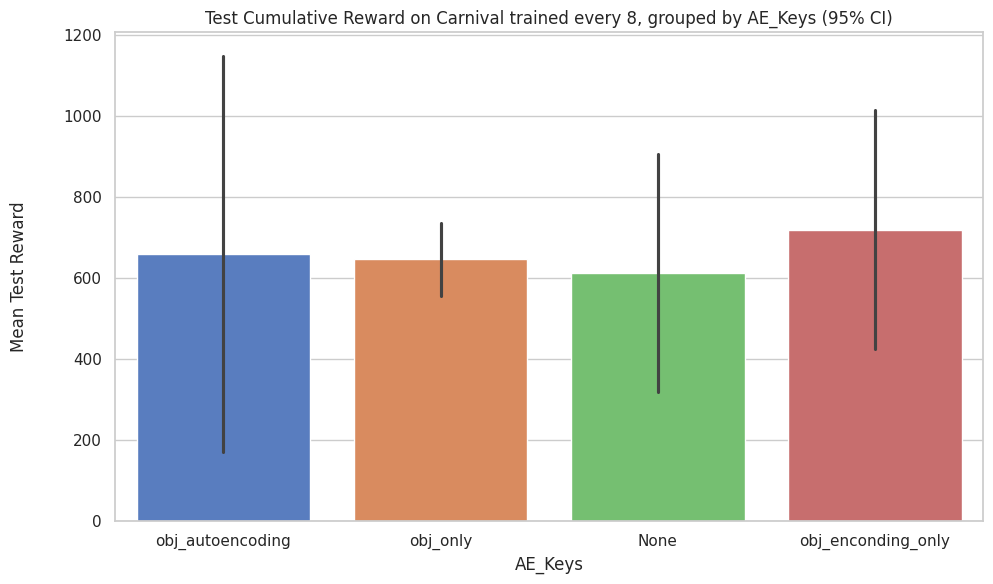

In [8]:
games = ['MsPacman', 'Breakout', 'Assault', 'Carnival']

for game in games:
    print(f"Processing {game}...")
    base_dir = f'logs/runs/dreamer_v3/{game}NoFrameskip-v4'
    update_viz(base_dir)